# Convert a Delft3D4 NetCDF output result to the Ugrid NetCDF format that can be used by D-Eco Impact

NB.\
To use this conversion script make sure that your Delft3D 4 calculation has produced netCDF output, else this will require a re-run of your model.\
The following lines need to be included in the .MDF run input file for Delft3D 4 to write the require netCDF output file instead of the .dat files:

```
FlNcdf= #maphis#
ncFormat=4
```

In [1]:
#load required libraries and prepare logging
import os
import numpy as np
import dfm_tools as dfmt
import xugrid as xu
import xarray as xr
import datetime as dt
import logging


logger = logging.getLogger(__name__)

from DEcoImpact_conv_func import DEIModel

c:\Users\weeber\AppData\Local\miniconda3\envs\HDFPython\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#configuration
ds_in = r'..\tests\rawdata\delft3d4flow_output_example.nc' #input location of file that needs to be converted
ds_out = r'input_DEI_Delft3D4_output.nc'               #output location of file that can be loaded by D-Eco Impact
crs_code = "epsg:4326"                                 #coordinate system applicable to file


In [3]:
#Load the Delft3D 4 Netcdf export and convert to a ugrid format
uds = dfmt.open_dataset_delft3d4(ds_in)
print(uds)

<xarray.Dataset> Size: 3MB
Dimensions:        (mesh2d_nFaces: 2160, LSTSCI: 2, SIG_LYR: 1, SIG_INTF: 2,
                    KMAXOUT: 2, KMAXOUT_RESTR: 1, time: 16, LSED: 1, KMAX: 1,
                    LSEDTOT: 1, nlyr: 1, nlyrp1: 2, avgtime: 1)
Coordinates:
    XZ             (mesh2d_nFaces) float64 17kB dask.array<chunksize=(2160,), meta=np.ndarray>
    YZ             (mesh2d_nFaces) float64 17kB dask.array<chunksize=(2160,), meta=np.ndarray>
  * SIG_LYR        (SIG_LYR) float32 4B -0.5
  * SIG_INTF       (SIG_INTF) float32 8B 0.0 -1.0
  * KMAXOUT        (KMAXOUT) int32 8B 0 1
  * KMAXOUT_RESTR  (KMAXOUT_RESTR) int32 4B 0
  * time           (time) datetime64[ns] 128B 2020-05-03T01:00:00 ... 2020-05...
  * mesh2d_nFaces  (mesh2d_nFaces) int64 17kB 0 1 2 3 4 ... 2156 2157 2158 2159
Dimensions without coordinates: LSTSCI, LSED, KMAX, LSEDTOT, nlyr, nlyrp1,
                                avgtime
Data variables: (12/29)
    ALFAS          (mesh2d_nFaces) float32 9kB dask.array<chunksize=

In [4]:
#drop some variables that might be challenging for writing.
# NB.  MFTAVG was already dropped for writing test set, drop as well if still present
#uds = uds.drop_vars(["MFTAVG","MORAVG"]) #"NAMCON","GRAVITY",
mesh2d = uds.drop_vars(["MORAVG"]) #"GRAVITY",

#drop grid
grid = mesh2d["grid"].copy()
mesh2d = mesh2d.drop_vars(["grid"])

#Convert to ugrid dataset
#mesh2d = uds_cor.ugrid.to_dataset()

#drop grid attribute and replace it with mesh2d
for i in mesh2d.data_vars:
 if("grid" in mesh2d[i].attrs):
    del mesh2d[i].attrs["grid"]
 if(len([i for i in mesh2d[i].dims if i in ["mesh2d_nFaces", "mesh2d_nNodes", "mesh2d_nEdges"]]) > 0):
    mesh2d[i].attrs["mesh"] = "mesh2d"


In [5]:
#initialize
DEI = DEIModel()
cwd = os.getcwd()
DEI.set_root(root = cwd)



#read Netcdf
DEI._mesh2d = mesh2d


#export result
DEI.write_mesh(fn_temp = "example_output_data/temporary_file.nc", fn_ecoimpact = "example_output_data/"+ds_out)

print("Done.")

Done.


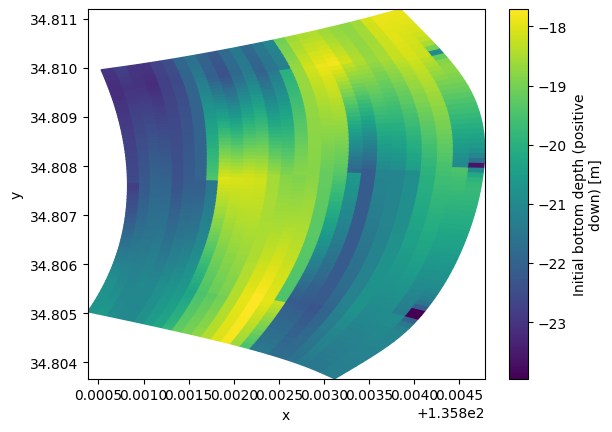

In [6]:
#visualize results (DP0 is initial bathymetry)
with xu.open_mfdataset("example_output_data/"+ds_out) as result:
    result["DP0"].ugrid.plot()